<a href="https://colab.research.google.com/github/RGivisiez/recommendation-systems/blob/main/Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins import projector

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

In [ ]:
%load_ext tensorboard

In [ ]:
path = 'ml-latest-small/'

In [ ]:
!ls $path | grep ".csv"

links.csv
movies.csv
ratings.csv
tags.csv


---------------------------------------------------
# Open, clean and explore the datasets

In [ ]:
movies = pd.read_csv(path + 'movies.csv')
ratings = pd.read_csv(path + 'ratings.csv').drop('timestamp', axis=1)
tags = pd.read_csv(path + 'tags.csv').drop('timestamp', axis=1)

### Functions

In [ ]:
def test_max_min(series, num_type):

  '''
    Change a pandas series to a specific dtype listed in num_type.
    If the dtype change modifies the minimum or maximum values of the
    series, the dtype change is not made.

    The num_type can be a list of types in ascending order.

    series: pandas series.
    num_type: single entry or a list with numpy types.
  '''
  
  if isinstance(num_type, list):
    num_type = num_type
  else:
    num_type = [num_type]

  for type_ in num_type:

    is_same = (series == series.astype(type_)).all()

    if is_same:
      return series.astype(type_)
    else:
      print('{0} type was not change. \n'.format(series.name))
      return series

Change the numerical types to no waste RAM.

In [ ]:
for name in ['userId', 'movieId']:

  tags[name] = test_max_min(tags[name], [np.int32])

  ratings[name] = test_max_min(ratings[name], np.int32)

  if name == 'movieId':
    movies[name] = test_max_min(movies[name], np.int32)

#ratings['rating'] = test_max_min(ratings['rating'], np.float16) #pd.pivot does not accept np.float16

In [ ]:
def MultLabelBin(df, col_name, return_estimator=False):

  '''
    Given a pandas DataFrame and a column name, transform the series df[col_name]
    in a one hot encode matrix. Every entry of df[col_name] must contain a list.

    df: Pandas DataFrame
    col_name: A column name present in df.
    return_estimator: If True, return the scikit-learn estimator used.

    returns a new pandas DataFrame with the new one hot features. 
  '''

  series = df[col_name].reset_index(drop=True)
  
  mult_label = MultiLabelBinarizer().fit(series)
  OH_matrix = mult_label.transform(series)

  labels = list(mult_label.classes_)

  OH_matrix = pd.DataFrame(OH_matrix, columns=labels)

  df = pd.concat([df, OH_matrix], axis=1).drop(col_name, axis=1)
  
  df[labels] = df[labels].astype(np.uint8)

  if return_estimator == True:
    return df, labels, mult_label
  else:
    return df, labels

## Movies dataset

1. Split the movies genres.
2. Transform the genres from every movie in a one hot vector.
3. Visualize the movie dataset.

## Prepare the dataset

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#@title Split the movies genres
movies['genres'] = movies['genres'].apply(lambda x: x.lower().split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]


In [ ]:
#@title For every genre in movie dataset, create a one hot vector.
movies, genre_labels = MultLabelBin(movies, 'genres')
movies.head()

,movieId,title,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualizations

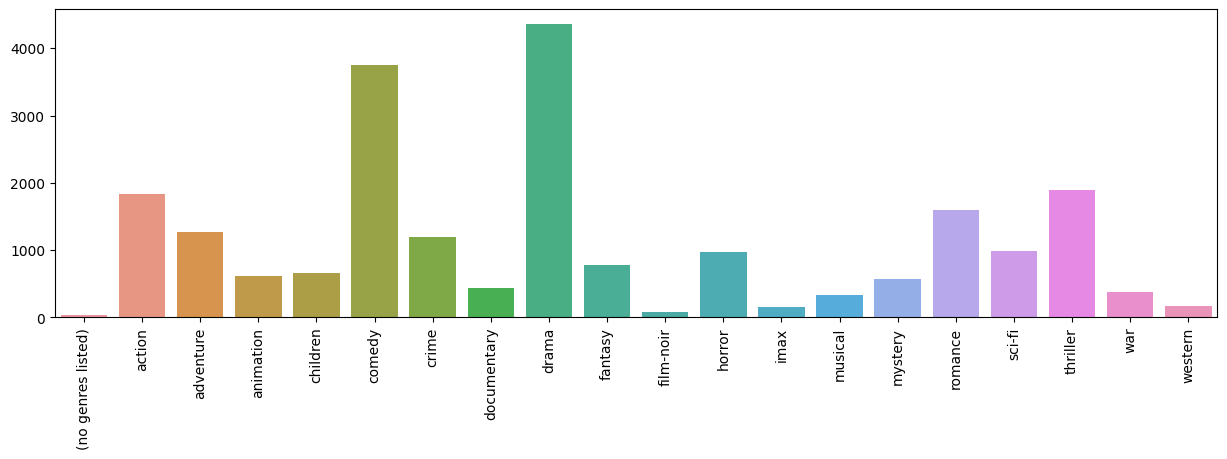

In [ ]:
#@title Movie genres in the dataset
plt.figure(figsize=(15, 4))
sns.barplot(x=movies[genre_labels].sum().index, y=movies[genre_labels].sum())
plt.xticks(rotation=90)
plt.show()

## User Tags dataset

### Prepare the dataset

1. Clear entries without tags.
2. Merge the movies dataset with the user tags dataset.

In [ ]:
#@title Clear rows with NaNs
tags = tags[~tags['tag'].isna()]

In [ ]:
#@title Merge tags and movie datasets
tags = pd.merge(tags, movies, on='movieId', how='left')
tags['tag'] = tags['tag'].str.lower()
tags.head()

,userId,movieId,tag,title,(no genres listed),action,adventure,animation,children,comedy,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,2,60756,funny,Step Brothers (2008),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,60756,highly quotable,Step Brothers (2008),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,60756,will ferrell,Step Brothers (2008),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2,89774,boxing story,Warrior (2011),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,89774,mma,Warrior (2011),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#@title Ignore tags that the same as any movie genre.
tags = tags[~tags['tag'].isin(genre_labels + ['Science Fiction'])]

In [ ]:
#@title Create a dictionary to store tags per movie.

genre_user_tags = {}

most_freq = tags[['tag'] + genre_labels].groupby('tag').sum()

for genre in genre_labels:

  genre_tags = most_freq[genre].sort_values(ascending=False)

  genre_max = genre_tags.max()
  genre_tags = genre_tags.sort_values(ascending=False)[1:] / genre_max
  genre_tags = genre_tags[genre_tags > 0.05]

  genre_user_tags[genre] = genre_tags

del most_freq

### Visualizations

1. Visualize tags by genre.
2. Visualize tags by movies.
3. Make a word cloud.

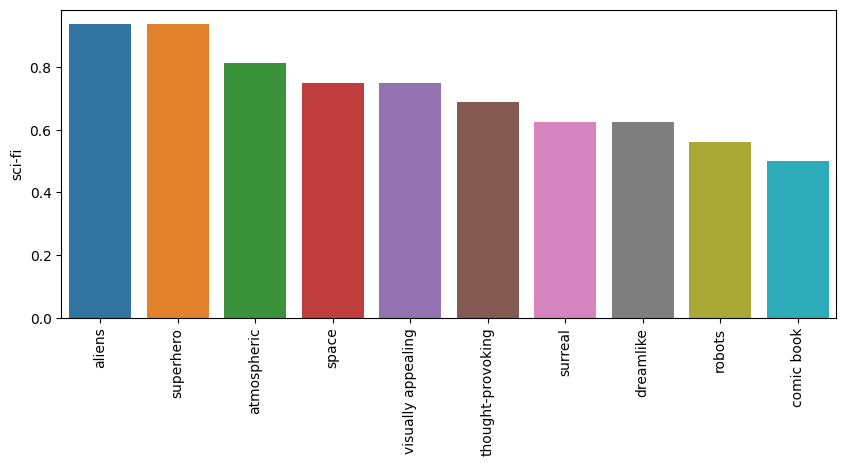

In [ ]:
#@title These are tags that best describe a movie genre.
#@markdown **genre**: (no genres listed), action, adventure, animation, children, comedy, crime, documentary, drama, fantasy, film-noir, horror, imax, musical, mystery, romance, sci-fi, thriller, war, western
genre = "sci-fi" #@param {type:"string"}
n_tags = 10 #@param {type:"number"}

plt.figure(figsize=(10, 4))
sns.barplot(data=genre_user_tags[genre].reset_index()[:n_tags], x='tag', y=genre)
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#@title Group tags by movie.
tags_per_movie = pd.pivot_table(tags, index=['title', 'tag'], values='userId', aggfunc='count')
tags_per_movie.rename(columns={'userId':'n_user'}, inplace=True)

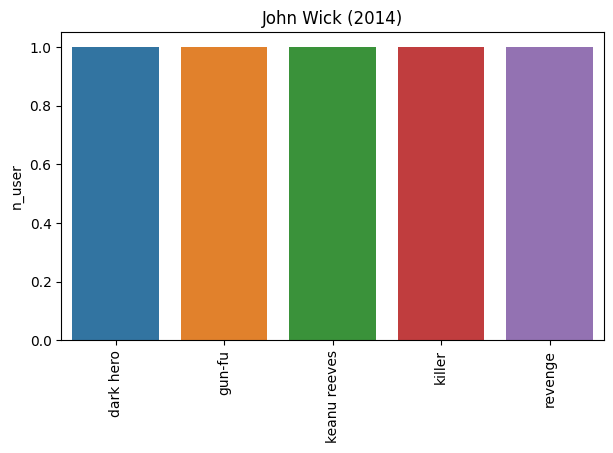

In [ ]:
#@title These are tags that best describe each movie.
n_tags =  5#@param {type:"number"}
filme_id =  65#@param {type:"integer"}

movie_name = tags['title'].unique()[filme_id]

plt.figure(figsize=[n_tags + 2, 4])
df = tags_per_movie.loc[movie_name].sort_values('n_user', ascending=False)[:n_tags].reset_index()

plt.title(movie_name)
sns.barplot(data=df, y='n_user', x='tag')
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

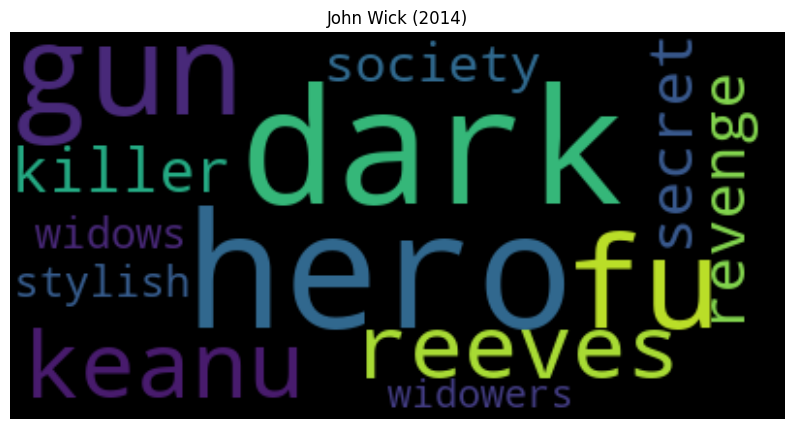

In [ ]:
#@title Movies Word Cloud.
filme_id =  65#@param {type:"integer"}

#movie_name = "Pulp Fiction (1994)" #@param {type:"string"}

movie_name = tags['title'].unique()[filme_id]

text =' '.join([tag for tag in tags_per_movie.loc[movie_name].index.to_list()])
text = text.replace('movie', "").replace('movies', "")
text = text.replace('film', "")
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=[10, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(movie_name)
plt.axis("off")
plt.show()

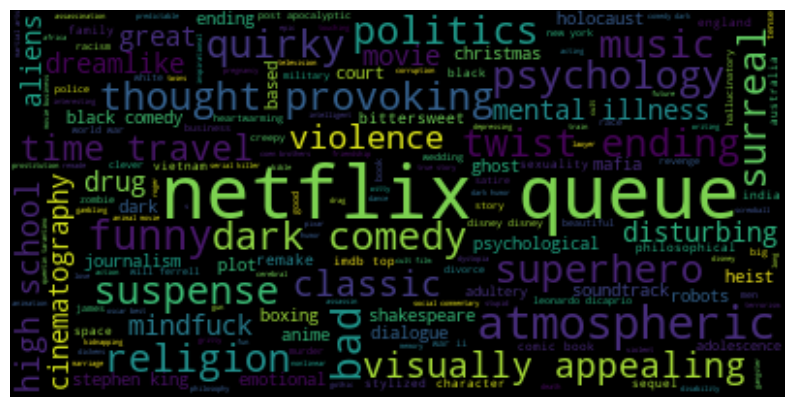

In [ ]:
#@title Considering all tags, this is the dataset tags word cloud
text =' '.join([tag for tag in tags['tag'].values])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=[10, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Ratings dataset

### Prepare the dataset

In [ ]:
#@title Merge ratings and movies datasets
ratings = pd.merge(ratings, movies[['movieId', 'title']], on='movieId', how='left')
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


### Visualizations

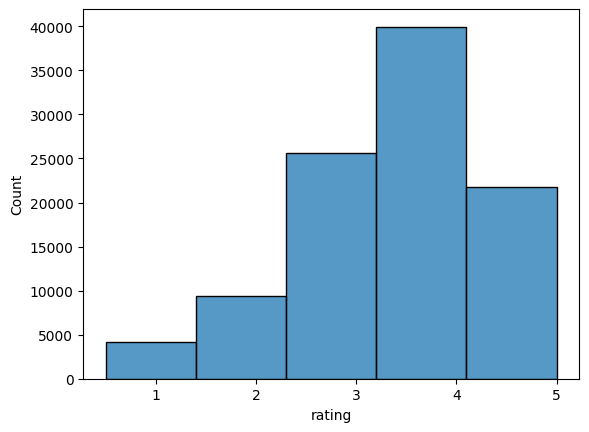

In [ ]:
#@title Most of the ratings are around 4.
sns.histplot(data=ratings['rating'], bins=5)
plt.show()

> Users may have a different bias when rating movies. For example, some users always rate movies with four or more stars, while others might do the opposite, rating more movies with fewer stars. Because of this, it is a good practice to center ratings using the user's rating mean.

In [ ]:
#@title Store rating mean per user
mean_reating_by_user = ratings[['userId', 'rating']].groupby('userId').mean().to_dict()['rating']


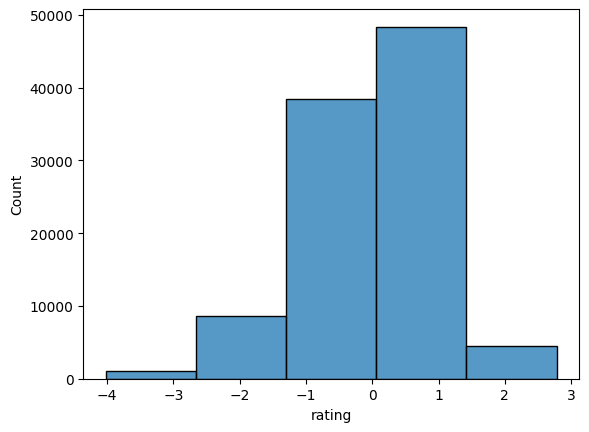

In [ ]:
#@title Rating shifted by user's rating mean
aux = ratings['rating'] - ratings['userId'].map(user_rating_mean)

sns.histplot(data=aux, bins=5)
plt.xlabel('rating')
plt.show()

> Netflix only uses like or dislike as a measure to rate a movie. So, it might be interesting to use this feature instead of a rating going from $0$ to $5$

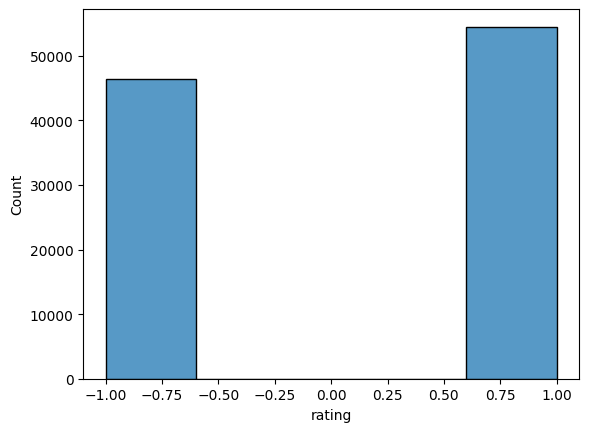

In [ ]:
#@title Rating distribution with dislike or like.
aux = aux.apply(lambda x: 1 if x > 0 else -1)
sns.histplot(data=aux, bins=5)
plt.xlabel('rating')
plt.show()

In [ ]:
#@title Make a dataset with rating mean and count
aux = ratings.pivot_table(index='title', values='rating', aggfunc=['mean', 'count'])

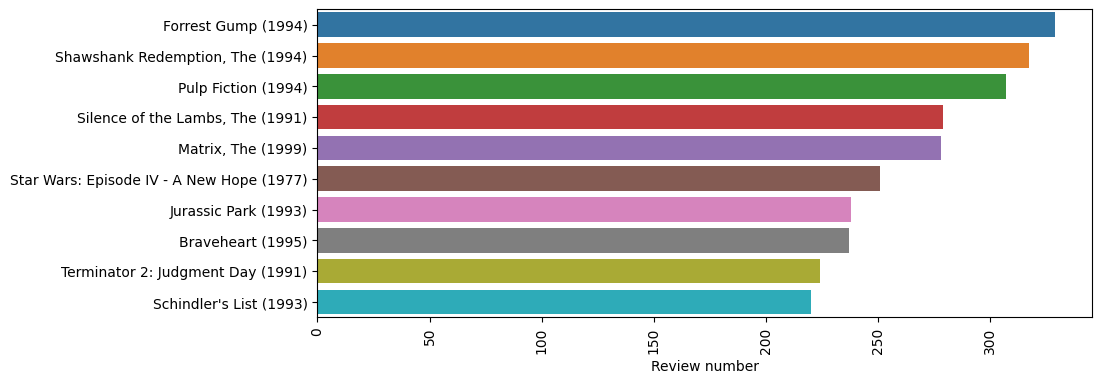

In [ ]:
#@title Famous movies are more reviwed.
plt.figure(figsize=[10, 4])
sns.barplot(data = aux[('count', 'rating')].sort_values(ascending=False).reset_index()[:10], y='title', x=('count', 'rating'), orient='h')
plt.xlabel('Review number')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

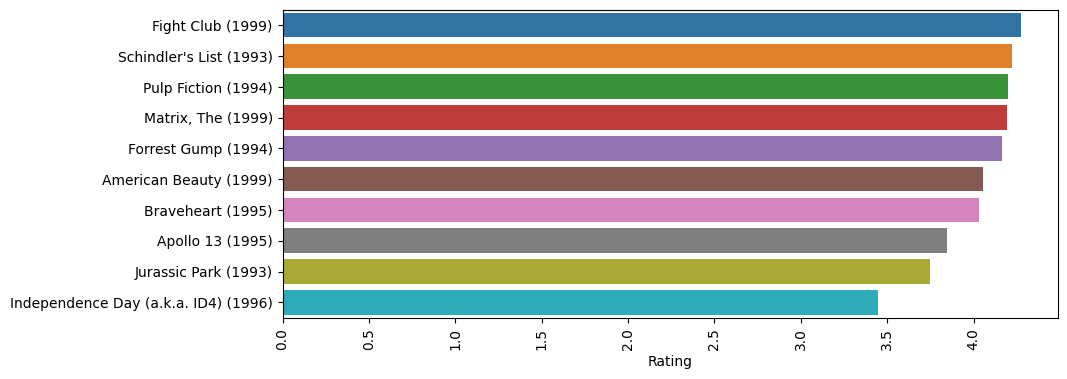

In [ ]:
#@title Considering movies with more than 200 review, these are the top 10.
plt.figure(figsize=[10, 4])
data = aux[aux[('count', 'rating')] > 200]
sns.barplot(data = data.reset_index()[:10].sort_values(('mean', 'rating'), ascending=False), y='title', x=('mean', 'rating'), orient='h')
plt.xlabel('Rating')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

______________________________________________________________________________
# Recommendation system using Nearest Neighbors Search

The main idea is to create a recommendation system based on user similarities. First, we will create a list of similar users for each user in the test dataset. Then, using only information about similar users and their watched movies, we will recommend movies for each user in the test dataset.

> Nearest Neighbors Search (NNS) can be seen as a form of proximity search. The problem that NNS solves is that given a dataset with $N$ points and a query point $q$, what are the $K$ closest points of $q$. For a more specific example, consider the MovieLens dataset that contains $N$ users and their movie preferences. A typical problem that NNS can solve using this dataset is that given a new user $q$ (query) and its movies preferences, which are the $K$ most similar users to the new user $q$.

## Create a list of similar users

### Prepare the dataset

#### Functions

In [ ]:
def count_genres(ratings, genre_labels):
  '''
    Create a feature that holds the number of movie watched by genre for every
    user.
  '''

  user_count_genre = ratings[['userId'] + genre_labels].groupby('userId').sum()

  new_cols = user_count_genre.columns + '_count'
  old_cols = user_count_genre
  map_cols = {old:new for old, new in zip(old_cols, new_cols)}

  user_count_genre.rename(columns=map_cols, inplace=True)

  return user_count_genre

#### Prepare the dataset

In [ ]:
#@title Merge ratings and movies dataset
ratings = pd.merge(ratings, movies[['movieId'] + genre_labels], on='movieId', how='left')
ratings.drop('title', axis=1, inplace=True)

> Each row of the final dataset will contain user's information about the number of movie watched by genre and the rating of each movie watched.

In [ ]:
#@title Final dataset
df_by_user = pd.pivot_table(ratings, index='userId', columns='movieId', values='rating').fillna(0)
df_by_user = pd.merge(df_by_user, count_genres(ratings, genre_labels), on='userId')
df_by_user

,1,2,3,4,5,6,7,8,9,10,...,film-noir_count,horror_count,imax_count,musical_count,mystery_count,romance_count,sci-fi_count,thriller_count,war_count,western_count
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,1.0,17.0,0.0,22.0,18.0,26.0,40.0,55.0,22.0,7.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,0.0,2.0,1.0,4.0,10.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,1.0,1.0,5.0,15.0,7.0,5.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,1.0,16.0,23.0,58.0,12.0,38.0,7.0,10.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,5.0,1.0,11.0,2.0,9.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,8.0,52.0,16.0,44.0,91.0,355.0,79.0,199.0,65.0,17.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,35.0,1.0,5.0,17.0,29.0,36.0,61.0,6.0,2.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,4.0,97.0,12.0,33.0,69.0,106.0,167.0,259.0,19.0,11.0


### Split the dataset in train and test.

> The same userIds in the train and test dataset will be used throughout the analysis.

In [ ]:
# Get the last 50 user as a test dataset.
train_sim = df_by_user[:-50]
test_sim = df_by_user[-50:]

In [ ]:
# Dictionary to convert between movieId and title.
id_to_title = movies[['movieId', 'title']].set_index('movieId').to_dict()['title']

### Find similar users 

1. "Train" the algorithm Nearest Neighbors (NN) using the train dataset.
1. For every userId in the test dataset, use the NN algorithm to find a set of similar users.

#### Functions

In [ ]:
def get_trueIds(indices, df, trueId_col_name):

  trueIds = []

  for row in indices:

    trueIds.append(df.reset_index().loc[row, trueId_col_name].values)

  return np.asarray(trueIds)

#### Find 10 similar users for each user in the dataset

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([('minmax', MinMaxScaler())])

n_neighbors = 20

X_user = train_sim.reset_index(drop=True).to_numpy()
y_user = test_sim.reset_index(drop=True).to_numpy()

X_user = pipe.fit_transform(X_user)
y_user = pipe.fit_transform(y_user)

user_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
user_knn = user_knn.fit(X_user)

In [ ]:
#Get the similar indices and distances.
sim_distances, sim_indices = user_knn.kneighbors(y_user, 10)

In [ ]:
#These Ids does not correspond to the same userId in the dataframe.
sim_indices[:2]

array([[ 67, 433, 379, 278, 238, 248, 327, 479, 304,  17],
       [479,  67, 424, 329, 356,  63, 214, 238, 281, 285]])

In [ ]:
#These Ids does correspond to the same userId in the dataframe.
trueId_sim_users = get_trueIds(sim_indices, train_sim, 'userId')
trueId_sim_users[:2]

array([[ 68, 434, 380, 279, 239, 249, 328, 480, 305,  18],
       [480,  68, 425, 330, 357,  64, 215, 239, 282, 286]])

In [ ]:
#Store a dictionary that contains a userId and a list of its similar user.
userId_and_similar_userIds = {test_userId:similar_userIds for test_userId, similar_userIds in zip(test_sim.index.to_list(), trueId_sim_users)}

## Recommend movies

1. Choose a userId.
3. For every movie watched by the user, recommend $10$ movies.
2. To do this, consider a dataset containing only information about similar users.


#### Create a list of tags per movies.

In [ ]:
max_ntags = 20

movie_tags = {}

for title in movies['title'].unique():

  try:
    movie_tags[title] = tags_per_movie.loc[title].sort_values('n_user', ascending=False)[:max_ntags].reset_index()['tag'].values
  except:
    movie_tags[title] = ['None']

### Prepare the dataset

In [ ]:
#@title Create a dataset containing only users in the test dataset and in the similar user list
Ids = np.concatenate((np.asarray(test_sim.index.to_list()), np.unique(trueId_sim_users)))
df_movies = ratings.set_index('userId').loc[Ids]
df_movies.head()

,movieId,rating,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
userId,,,,,,,,,,,,,,,,,,,,,
561,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
561,2,4.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
561,5,3.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
561,6,4.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
561,31,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#@title Create a feature with the $k$ most relevant tags for each movie
df_movies['user_tags'] = df_movies['movieId'].map(id_to_title).map(movie_tags)
df_movies.head()

,movieId,rating,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,user_tags
userId,,,,,,,,,,,,,,,,,,,,,
561,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,"[pixar, fun]"
561,2,4.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[game, magic board game, robin williams]"
561,5,3.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[pregnancy, remake]"
561,6,4.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,[None]
561,31,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[high school, teacher]"


### Split in train and test

> The userIds in the train and test dataset are the same as defined above.

In [ ]:
#@title Split the dataset in train and test.
train_movie = df_movies.loc[np.unique(trueId_sim_users)]
test_movie = df_movies.loc[test_sim.index.to_list()]

### Create a one hot encond for each tag in the movies tags list. 

In [ ]:
#@title Create a one hot encode for each movie tag in the train dataset.
train_movie, movie_labels, movies_est = MultLabelBin(train_movie.reset_index(), 'user_tags', True)
train_movie = train_movie.set_index('userId')
train_movie.head()

,movieId,rating,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
userId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,4.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,4.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,47,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,5.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#@title With the estimator created using the train dataset, transform to one hot all the tags in test dataset. (Some tags that are not in the train dataset will be ignored)
OH_tags = pd.DataFrame(movies_est.transform(test_movie['user_tags']), columns=movies_est.classes_)

test_movie = pd.concat([test_movie.reset_index(), OH_tags], axis=1)
test_movie = test_movie.set_index('userId')

test_movie.head()

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['abstract', 'allegorical', 'bizzare', 'nightmare', 'philosopical', 'reciprocal spectator', 'symbolic', 'transvestite', 'uncomfortable', 'understated', 'unsettling'] will be ignored
  warnings.warn(


,movieId,rating,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
userId,,,,,,,,,,,,,,,,,,,,,
561,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
561,2,4.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
561,5,3.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
561,6,4.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
561,31,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Recommend $10$ movies

1. For every user in the test dataset, recommend $10$ movies for each movie watched by the user.

2. Take the list of recommended movies and compare with the list of movies watched by the user, movies that are in both list count as a correct recommendation.

#### Functions

In [ ]:
def train(df, pipeline, sim_users):
  
  df_train = df.loc[sim_users].groupby('movieId').mean()

  movieId_index = df_train.index

  df_train = df_train.reset_index(drop=True)

  pipeline = pipeline.fit(df_train.to_numpy())

  df_train = pipeline.transform(df_train.to_numpy())

  knn_estimator = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
  knn_estimator = knn_estimator.fit(df_train)

  return knn_estimator, pipeline, movieId_index

In [ ]:
def predict(df, userId, pipeline, knn_estimator, recom_n=10):

  df_test = df.loc[userId]

  X_movie_recomend = df_test.groupby('movieId').mean()
  movieId_index = X_movie_recomend.index

  X_movie_recomend = X_movie_recomend.reset_index(drop=True)
  X_movie_recomend = pipeline.transform(X_movie_recomend.to_numpy())

  mv_distances, mv_indices = knn_estimator.kneighbors(X_movie_recomend, recom_n)

  return mv_distances, mv_indices, movieId_index

In [ ]:
def print_recom(movie_name, recom_movies, userId, n=2):
  
  movie_name = movie_name.map(id_to_title).values
  recom_movies = recom_movies.map(id_to_title).to_numpy()[movie_indices[:2]]

  for i in range(n):

    print('\nBecause the user {1} watched: {0}'.format(movie_name[i], userId))

    if movie_name[i] == recom_movies[i, 0]:
      print('\nWe recommended: {0}'.format(recom_movies[i, 1:]))
    else:
      print('\nWe recommended: {0}'.format(recom_movies[i]))

#### Recommendation loop

> For the sake of clarity, we will only print the first two recommendations for the first user.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

result = []

for userId, sim_users in userId_and_similar_userIds.items():
  
  pipe = Pipeline([('minmax', MinMaxScaler())])

  movies_knn, pipe, train_movie_index = train(train_movie, pipe, sim_users)

  #movie_indices are not the same as movie Ids.
  _, movie_indices, test_movie_index = predict(test_movie, userId, pipe, movies_knn, recom_n=10)  

  partial_res = np.isin(train_movie_index.to_numpy()[movie_indices], test_movie_index.to_numpy()).sum(axis=1)
  
  if (userId == list(userId_and_similar_userIds.keys())[0]):
    print_recom(test_movie_index, train_movie_index, userId, 2)
  
  result.append(np.mean(partial_res))

mean = np.mean(np.asarray(result))


Because the user 561 watched: Toy Story (1995)

We recommended: ["Bug's Life, A (1998)" 'Monsters, Inc. (2001)' 'Antz (1998)'
 "Emperor's New Groove, The (2000)" 'Shrek the Third (2007)'
 'Adventures of Rocky and Bullwinkle, The (2000)' 'Toy Story 3 (2010)'
 'Shrek (2001)' 'Inside Out (2015)']

Because the user 561 watched: Jumanji (1995)

We recommended: ['Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'
 'NeverEnding Story, The (1984)' 'Indian in the Cupboard, The (1995)'
 'Golden Compass, The (2007)' 'Bridge to Terabithia (2007)'
 'Ponyo (Gake no ue no Ponyo) (2008)' 'Atlantis: The Lost Empire (2001)'
 'Zathura (2005)' 'Borrowers, The (1997)']


In [ ]:
#@title Mean accuracy for $10$ recommended movies.
print('\nMean acc for {0} recommended movies: {1}'.format(movie_indices.shape[1], mean.round(0)))


Mean acc for 10 recommended movies: 3.0


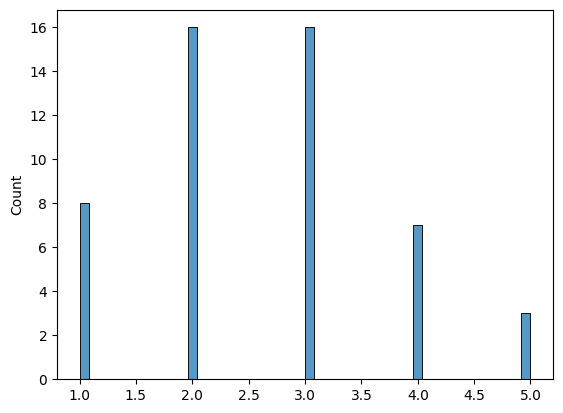

In [ ]:
#@title The predictions are good enough for a simple model. The model correctly recommends 2 to 3 movies most of the time, as can be seen in histogram below.
sns.histplot(np.asarray(result).round(0), bins=50)
plt.show()

_______________________________________________________________________________
# Matrix Factorization

Consider the rating matrix $\mathbf{R}$ given by user's rating per movie,

| |Movie 1|Movie 2|
|---|---|---|
|User 1| 5.0 | 3.0 |
|User 2| 0.0| 1.0 |

The ideia behind the matrix factorization method is to reconstruct $\mathbf{R}$ using a approximated matrix $\hat{\mathbf{R}}$ given by,

$$\hat{\mathbf{R}} = \mathbf{PQ}^\top,$$

where $\mathbf{P}$ is a latent matrix representing user-movie interaction and $\mathbf{Q}$ is a latent matrix representing items characteristics. In other words, what we want to do is build two matrices $\mathbf{P}$ and $\mathbf{Q}$ with unknown parameters (weights) that will be learned by the algorithm. The learning process is carried out until $\hat{\mathbf{R}}$  be equal to $\mathbf{R}$, that is, we want to chose the matrices parameters such that it minimize the difference given by,

$$||{\mathbf{R}} - \hat{\mathbf{R}}|| = ||{\mathbf{R}} - \mathbf{PQ}^\top ||.$$

The matrix $\mathbf{P}$ has dimension of number of user per latent dimension, and matrix $\mathbf{Q}$ has dimension of number of movies per latent dimension. The latent dimension size can be freely chosen, the idea is that each latent dimension represents a feature learned by the algorithm. As a example of such features, the $\mathbf{P}$ matrix can learn about movie genres or popularity, while the $\mathbf{Q}$ matrix can learn user's genre preference. Therefore, with a larger latent space, the algorithm can learn several features, although these features are not garanteed to be easily interpreted by humans. It is more likely that each feature will be a non-linear combination of other human interpretable features such as genres and popularity.

> In the end we will use a t-distributed Stochastic Neighbor Embedding (t-SNE) to see some of the features learned by $\mathbf{Q}$ matrix.

**Matrices:**

- $\mathbf{R}$: Train or test dataset representing the user ratings by movie. (user x movie)
- $\hat{\mathbf{R}}$: Matrix representing the user ratings by movie. (user x movie)
- $\mathbf{P}$: Latent matrix representing user-movie interaction. (user x latent dim)
- $\mathbf{Q}^\top$: Latent matrix representing item characteristic. (latent dim x movie)

## Prepare the dataset



In [ ]:
movies = pd.read_csv(path + 'movies.csv')
ratings = pd.read_csv(path + 'ratings.csv').drop('timestamp', axis=1)
ratings = ratings[['userId', 'movieId', 'rating']]

In [ ]:
#@title Create a dictionary containing the map between movieId and userId to the embedding dimensions
movieId_map = {movieId:newId for movieId, newId in zip(ratings['movieId'].unique(), np.arange(0, ratings['movieId'].unique().shape[0]))}
reverse_movieId_map = {value:key for key, value in movieId_map.items()}

userId_map = {userId:newId for userId, newId in zip(ratings['userId'].unique(), np.arange(0, ratings['userId'].unique().shape[0]))}
reverse_userId_map = {value:key for key, value in userId_map.items()}

In [ ]:
ratings['movieId'] = ratings['movieId'].map(movieId_map)
ratings['userId'] = ratings['userId'].map(userId_map)

In [ ]:
#@title Create the R matrix using a sparse tensor
R = tf.SparseTensor(indices=ratings[['userId', 'movieId']].values,
                    values=ratings['rating'].values,
                    dense_shape=[ratings['userId'].nunique(),
                                 ratings['movieId'].nunique()]
                )

----------------------------------------------------------
## Simple Implementation

In [ ]:
#@title Define the latent dimension and create the P and Q matrices
latent_dim = 30 #@param {type:"integer"}
P = tf.Variable(tf.random.normal(shape=[ratings['userId'].unique().shape[0], latent_dim], stddev=0.5))
Q = tf.Variable(tf.random.normal(shape=[ratings['movieId'].unique().shape[0], latent_dim], stddev=0.5))

### Train the model to minimize $||{\mathbf{R}} - \hat{\mathbf{R}}||$ using a Stochastic Gradient Descent (SGD).

In [ ]:
learning_rate = 10.0

opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)

epochs = 1000

for epoch in range(epochs):

  with tf.GradientTape() as tape:

    #Naive
    #dot_prod = tf.matmul(P, Q, transpose_b=True)
    #R_hat = tf.gather_nd(dot_prod, R.indices)

    #Better
    dot_prod = tf.gather(P, R.indices[:, 0]) * tf.gather(Q, R.indices[:, 1])
    R_hat = tf.reduce_sum(dot_prod, axis=1)

    loss = tf.losses.mean_squared_error(R.values, R_hat)

  grad = tape.gradient(loss, [P, Q])
  opt.apply_gradients(zip(grad, [P, Q]))

print(loss.numpy())

0.34066162


### Recommend movies

In [ ]:
def recommendations(R_hat, user_Id, recommend_n = 10):
    recom_list = R_hat.loc[user_Id].sort_values(ascending=False)[:recommend_n].index.to_list()
    return movies.set_index('movieId').loc[recom_list].reset_index(drop=True)

In [ ]:
#@title Get the R_hat matrix using the P and Q matrices
R_hat_df = pd.DataFrame(tf.matmul(P, Q, transpose_b=True).numpy())
R_hat_df.index = R_hat_df.index + 1
R_hat_df.columns = R_hat_df.columns.map(reverse_movieId_map)

In [ ]:
#@title Recommend 10 movies for a user. (user_Id > 0)
user_Id = 1 #@param {type:"integer"}
print('Recommended movies for user {0}:'.format(user_Id))
recommendations(R_hat_df, user_Id=user_Id)

Recommended movies for user 1:


,title,genres
0,"Jetée, La (1962)",Romance|Sci-Fi
1,Royal Flash (1975),Adventure|Comedy|Romance
2,Dead Meat (2004),Horror
3,Redline (2009),Action|Animation|Sci-Fi
4,Stranger Than Paradise (1984),Comedy|Drama
5,L.A. Slasher (2015),Comedy|Crime|Fantasy
6,Adam's Rib (1949),Comedy|Romance
7,Neon Genesis Evangelion: The End of Evangelion...,Action|Animation|Drama|Fantasy|Sci-Fi
8,Hype! (1996),Documentary
9,High School (2010),Comedy


-----------------------------------------------------------
## Same algorithm but using a TensorFlow custom layer

### Train the model to minimize $||{\mathbf{R}} - \hat{\mathbf{R}}||$ using a Stochastic Gradient Descent (SGD).

In [ ]:
#@title Create a custom layer that outputs R_hat
class dot_layer(keras.layers.Layer):
    def __init__(self, P_dim, Q_dim, latent_dim=30):
        super(dot_layer, self).__init__()
        self.P_dim = P_dim
        self.Q_dim = Q_dim
        self.P = self.add_weight(
            shape=(P_dim, latent_dim), initializer="random_normal", trainable=True,
            name='P'
        )
        self.Pb = self.add_weight(shape=(P_dim, 1), initializer="zeros", trainable=False,
                                  name='Pb')
        self.Q = self.add_weight(
            shape=(Q_dim, latent_dim), initializer="random_normal", trainable=True,
            name='Q'
        )
        self.Qb = self.add_weight(shape=(1, Q_dim), initializer="zeros", trainable=False,
                                  name='Qb')
    
    def call(self, inputs):
        dot = tf.matmul(self.P, tf.transpose(self.Q))
        R_hat = tf.gather_nd(dot, R.indices)

        self.add_loss(tf.reduce_sum(tf.square(self.P)) / self.P.shape[0] + tf.reduce_sum(tf.square(self.Q)) / self.Q.shape[0])
        return R_hat

In [ ]:
#@title Define the latent dimension.
latent_dim = 300 #@param {type:"integer"}

In [ ]:
#Initialize the custom layer
dot = dot_layer(R.shape[0], R.shape[1], latent_dim)

#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.SGD(learning_rate = 10)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#Define a regularization constant
lambda_ = 0.1

#Train the model
epochs = 3000

for epoch in range(epochs):

    with tf.GradientTape() as tape:
        R_hat = dot('None')

        loss = mse_loss_fn(R.values, R_hat)
        loss += sum(dot.losses) * lambda_
        
    grads = tape.gradient(loss, dot.trainable_weights)
    optimizer.apply_gradients(zip(grads, dot.trainable_weights))

print('MSE: {0:2.2f} and Loss: {1:2.2f}'.format(mse_loss_fn(R.values, R_hat).numpy(), loss.numpy()))

MSE: 0.11 and Loss: 0.81


### Recommend movies

In [ ]:
def recommendations(R_hat, user_Id, recommend_n = 10):
    recom_list = R_hat.loc[user_Id].sort_values(ascending=False)[:recommend_n].index.to_list()
    return movies.set_index('movieId').loc[recom_list].reset_index(drop=True)

In [ ]:
#@title Get the R_hat matrix using the P and Q matrices
R_hat_df = pd.DataFrame(tf.matmul(dot.P, dot.Q, transpose_b=True).numpy())
R_hat_df.index = R_hat_df.index + 1
R_hat_df.columns = R_hat_df.columns.map(reverse_movieId_map)

In [ ]:
#@title Recommend 10 movies for a user. (user_Id > 0)
user_Id = 1 #@param {type:"integer"}
print('Recommended movies for user {0}:'.format(user_Id))
recommendations(R_hat_df, user_Id=user_Id)

Recommended movies for user 1:


,title,genres
0,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
1,"Great Escape, The (1963)",Action|Adventure|Drama|War
2,Casablanca (1942),Drama|Romance
3,Doctor Zhivago (1965),Drama|Romance|War
4,Unforgiven (1992),Drama|Western
5,"Grand Day Out with Wallace and Gromit, A (1989)",Adventure|Animation|Children|Comedy|Sci-Fi
6,Patton (1970),Drama|War
7,Dead Poets Society (1989),Drama
8,Cool Hand Luke (1967),Drama
9,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


### t-SNE with Sckit-Learn

> In the t-SNE plot, the colors indicate the movie's mean rating and the point size is the movie's number of ratings.

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(dot.Q)

In [ ]:
#@title Create the embedded dataset with movie information
emb = pd.DataFrame(X_embedded)
emb['movieId'] = emb.reset_index()['index'].map(reverse_movieId_map)
emb = pd.merge(emb, movies, on='movieId')

In [ ]:
#@title Add rating mean on the dataset
aux = ratings.groupby('movieId').mean().reset_index().drop('userId', axis=1)
aux['movieId'] = aux['movieId'].map(reverse_movieId_map)
emb = pd.merge(emb, aux, on='movieId')

In [ ]:
#@title Add rating count on the dataset
aux = ratings.drop('userId', axis=1).groupby('movieId').count().reset_index()
aux['movieId'] = aux['movieId'].map(reverse_movieId_map)
emb = pd.merge(emb, aux, on='movieId')

In [ ]:
emb.rename(columns={'rating_x':'mean_rating', 'rating_y':'rating_count'}, inplace=True)

> Notice how t-SNE tries to isolate movies that have been rated more times from the others (points with bigger size means a higher number of ratings). Another cluster, easy to see, is that separates low-rated movies from the others (cluster with red points). There are small clusters around the main cluster, the features these small clusters describe are more difficult to identify, being probabily a combinantion of movie gender, popularity and rating.

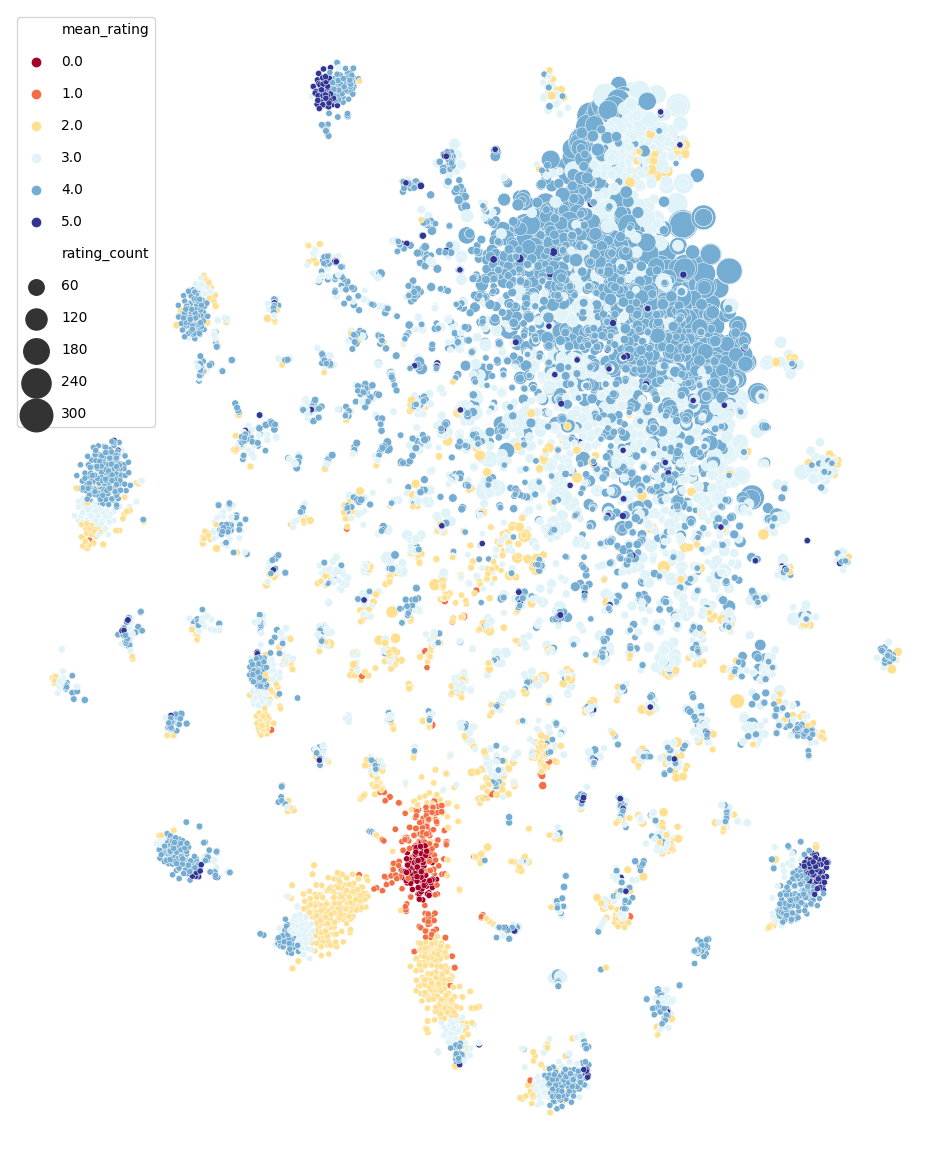

In [ ]:
#@title t-SNE plot
plt.figure(figsize=[12, 15])
sns.scatterplot(data=emb, x=0, y=1, hue=emb['mean_rating'].round(0), palette='RdYlBu',
                size='rating_count', sizes=(20, 600))
plt.axis('off')
plt.legend(labelspacing=1.3)
plt.show()

> One last comment about the clusters, it seems that the embedding matrix recognizes blockbuster movies from other movies because they are more reviewed. This could indicate a problem with the algorithm, it may be biased to recommend more blockbuster movies as they are rated more often and with a higher rating score.

### t-SNE with TensorBoard

> With TensorBoard is easier to visualize this embeddings since it plots the data in 3D and has a option to use PCA, t-SNE or UMAP.

> The same structure shown in the image above was seen one the TensorBoard with parameters: Perplexity 20 and Learning Rate 10.

In [ ]:
emb.set_index('movieId', inplace=True)

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='logs/movielens-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

#weights = tf.Variable(model.movie_model.layers[1].weights[0])

weights = tf.Variable(dot.Q)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  f.write('Title\tRatingMean\tRatingCount\n')
  for idx, movideId in enumerate(emb.index.to_list()):
    f.write("{0}\t{1:2.2f}\t{2}\n".format(emb.loc[movideId, 'title'], emb.loc[movideId, 'mean_rating'], emb.loc[movideId, 'rating_count']))

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
#weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir 'logs/movielens-example/' --host 0.0.0.0